### Name: Elan van Biljon


#### Student Number: 18384439

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from hmm_class import HMM
from gaussian import Gaussian
from utils import read_signatures, sign_norm

import itertools
import warnings
warnings.filterwarnings('ignore')

### A simple example

As a simple example.

We print the trained HMM parameters - **verify that they make sense to you.  Ensure you understand what the last row and column in the transition table are for.**

In [3]:
# Define signals
signal1 = np.array([[ 1. ,  1.1,  0.9, 1.0, 0.0,  0.2,  0.1,  0.3,  3.4,  3.6,  3.5]])
signal2 = np.array([[0.8, 1.2, 0.4, 0.2, 0.15, 2.8, 3.6]])

# Collect training data together
toy_data = np.hstack([signal1, signal2])
toy_lengths = [11, 7]

# Create and fit HMM model to data
toy_hmm = HMM()
toy_hmm.fit(toy_data,toy_lengths, 3)


toy_means = np.array([d.get_mean() for d in toy_hmm.dists])
toy_covs = np.array([d.get_cov() for d in toy_hmm.dists])
print ('Transition probabilities: ')
print (toy_hmm.trans)
print ('Means: ')
print (toy_means)
print ('Covariances: ')
print (toy_covs)

Transition probabilities: 
[[0.66666667 0.33333333 0.         0.        ]
 [0.         0.71428571 0.28571429 0.        ]
 [0.         0.         0.6        0.4       ]
 [1.         0.         0.         0.        ]]
Means: 
[[1.        ]
 [0.19285714]
 [3.38      ]]
Covariances: 
[[[0.02      ]]

 [[0.01702381]]

 [[0.112     ]]]


Discus transition probabilities:

This makes sense to me, There is a $A_{ij}$ probability of moving from state $i$ to state $j$. Here state $i$ is the row and state $j$ is the column. Another sanity check is the fact that all rows sum to one, meaning that there is a probability of 1 of transitioning from this state (it may be to the same state but that still counts as a transition). This just intuitively makes sense as we feel we transition, if we do not move into another state or stay in the same state, where are we?

Discus means:

The means are very easy to verify and understand, they are very close to the expected means (mentioned above).

Discus covariances:

These intuitively make sense. Most of our observations for the first state lie within 0.1 of the mean (quite a small spread) which leads us to expect a small covariance (which we see). The same goes for state 2. The more interesting state is state 3, there are observations that lie as far as 0.5 from the predicted mean, thus one would expect a larger covariance than that of the previous states. This is exactly what we see.

# Preparing the data.

(2, 1644)
[603, 510, 531]


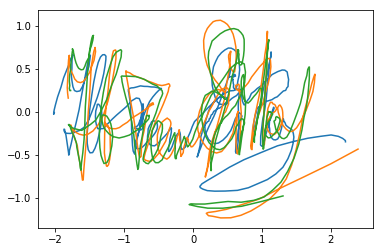

In [4]:
sign = read_signatures('./data/signatures/sign2/*.txt')
n_signs = len(sign)-12

# Get the norm of the first signature
data = sign_norm(sign[0][:2, :])
length = [sign[0].shape[1]]

# Plot the first one
plt.figure("Signatures: signatory 2")
plt.plot(data[0,:],data[1,:])

# Normalise and plot the rest of the signatures
for i in range(n_signs-1):
    signi = sign_norm(sign[i+1][:2, :])
    data = np.hstack((data,signi))
    length.append(sign[i+1].shape[1])
    plt.plot(signi[0,:],signi[1,:])
print (data.shape)
print (length)

### Training

Marks: 0

In [5]:
n_states = 5

# Create and fit HMM model to data
hmm = []
for i in np.arange(5):
    sign = read_signatures('./data/signatures/sign%d/*.txt' % (i+1))
    n_signs = len(sign)-12

    # Get the norm of the first signature
    data = sign_norm(sign[0][:2, :])
    length = [sign[0].shape[1]]

    # Normalise and plot the rest of the signatures
    for i in range(n_signs-1):
        signi = sign_norm(sign[i+1][:2, :])
        data = np.hstack((data,signi))
        length.append(sign[i+1].shape[1])

    signature_hmm = HMM()
    signature_hmm.fit(data, length, n_states)
    hmm.append(signature_hmm)

### Sampling from an HMM

Marks: 2

In [6]:
def _sample(self):
    from scipy.stats import multivariate_normal
    samples = np.array([0,0])
    states = np.array([])
    state = -1
    fin_state = self._n_states()

    state = draw_discrete_sample(self.trans[state])
    while state != fin_state:
        dist = self.dists[state]
        samples = np.vstack(
            [samples,
            multivariate_normal.rvs(
                mean=dist.get_mean(),
                cov=dist.get_cov()
                )]
            )
        states = np.append(states, state)
        state = draw_discrete_sample(self.trans[state])

    samples = samples[1:]
    return [samples, states]

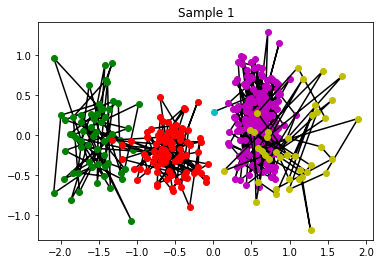

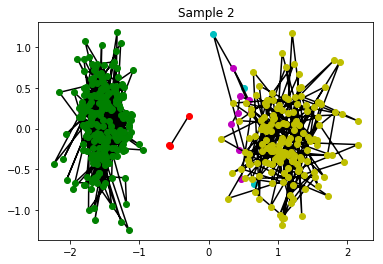

In [7]:
col_list = ['g', 'r', 'c', 'm', 'y', 'k', 'b']

sample_1, states_1 = hmm[1].sample()
sample_2, states_2 = hmm[1].sample()

plt.figure()
plt.title('Sample 1')
for i in np.arange(n_states):
    col = col_list[i % len(col_list)]
    point_set = sample_1[states_1 == i]
    plt.plot(point_set[:, 0], point_set[:, 1], 'black',
            point_set[:, 0], point_set[:, 1], col+'o')
    
plt.figure()
plt.title('Sample 2')
for i in np.arange(n_states):
    col = col_list[i % len(col_list)]
    point_set = sample_2[states_2 == i]
    plt.plot(point_set[:, 0], point_set[:, 1], 'black',
            point_set[:, 0], point_set[:, 1], col+'o')

The sample can certainly not pass as a signature, but the basic ideas are there. We can see that the last 3 states are bunched on top of each other (just like the last 3 letters), we can see a fairly large gap between the 2nd and the 3rd state (also like the letter groups - this is different to letters as there are more letters than there are states).

**This will probably look beter if we give it more training information.**

### Fitting a new signal to the model

continue with two signals for our toy example:

In [8]:
signal3 = np.array([[ 0.9515792,   0.9832767,   1.04633007,  1.01464327,  0.98207072,  1.01116689,
  0.31622856,  0.20819263,  3.57707616]])
seq3, ll3 = toy_hmm.viterbi(signal3)
print(seq3)
print(ll3)

signal4 = np.array([[ 1,   0.6,   0.5 , 3.57707616]]) 
seq4, ll4 = toy_hmm.viterbi(signal4)
print(seq4)
print(ll4)

[0 0 0 0 0 0 1 1 2]
2.2388148535736567
[0 0 1 2]
-7.249780564316458


Put some observations


### Visualise the different states - Viterbi on signatures

**Marks: 2**

In [21]:
signs = []
for i in np.arange(5):
    sign = read_signatures('./data/signatures/sign%d/*.txt' % (i+1))
    signs.append([])
    for j in np.arange(3, 15):
        signs[-1].append(sign_norm(sign[j][:2, :]))

figcount = 0
def plot_sig_viterbi(signator):
    global figcount
    figcount += 1
    plt.figure(figcount)
    plt.subplot(221)
    plt.title('Signator %d' % signator)
    points = signs[signator-1][0]
    plt.plot(points[0, :], points[1, :])
    seq, ll = hmm[signator-1].viterbi(signs[signator-1][0])

    plt.subplot(222)
    plt.title('Viterbi for Signator %d' % signator)
    for i in np.arange(n_states):
        col = col_list[i % len(col_list)]
        point_set = points[:, seq == i]
        plt.scatter(point_set[0, :], point_set[1, :], color=col)

In [23]:
print(signs)

[[array([[-4.43789674e-01, -4.55409967e-01, -4.67856806e-01,
        -4.86113791e-01, -5.09755483e-01, -5.40860411e-01,
        -5.73618428e-01, -6.08029534e-01, -6.58193657e-01,
        -7.02547633e-01, -7.60977201e-01, -8.27696550e-01,
        -8.97296637e-01, -9.69376357e-01, -1.04185718e+00,
        -1.10396970e+00, -1.15488736e+00, -1.18839892e+00,
        -1.19911966e+00, -1.20528224e+00, -1.19777034e+00,
        -1.17037269e+00, -1.13759034e+00, -1.09238549e+00,
        -1.03641122e+00, -9.77130769e-01, -9.23259363e-01,
        -8.71466486e-01, -8.22578683e-01, -7.77847937e-01,
        -7.40154988e-01, -7.06193656e-01, -6.85080268e-01,
        -6.73909749e-01, -6.63565774e-01, -6.61086141e-01,
        -6.58606507e-01, -6.63164669e-01, -6.74335188e-01,
        -6.90464975e-01, -7.08648955e-01, -7.23101317e-01,
        -7.36702800e-01, -7.47800314e-01, -7.58071283e-01,
        -7.62131001e-01, -7.56673289e-01, -7.59930797e-01,
        -7.59882127e-01, -7.63990515e-01, -7.68524343e

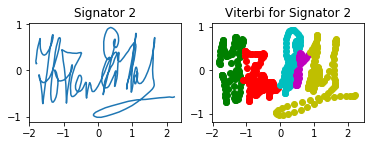

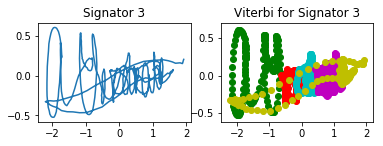

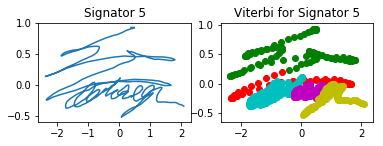

In [11]:
signators = [2, 3, 5]
for signator in signators:
    plot_sig_viterbi(signator)

### Calculating likelihoods

Marks: 2 for score, 2 for forward.

In [12]:
def _score(signal, seq, trans, dists):
    # set initial variables (time and state)
    current_state = -1
    t = 0

    # get log loglik for first step
    # (this is simply the transition probability)
    loglik = np.log(trans[current_state][seq[0]])
    current_state = seq[0]

    # loop through sequence and get the log sum of the probabilities for
    # all states in the sequence
    for next_state in seq[1:]:
        transition_prob = np.log(trans[current_state][next_state])
        state_prob = dists[current_state].loglik(signal[:, t])
        loglik += transition_prob + state_prob

        current_state = next_state
        t += 1

    # do the last step (from state N-1 to state N)
    transition_prob = np.log(trans[current_state][current_state+1])
    state_prob = dists[current_state].loglik(signal[:, t])
    loglik += transition_prob + state_prob

In [13]:
def _forward(signal, trans, dists):
    N = len(dists)
    T = signal.shape[1]

    # setup step
    current_a = np.log(np.array(trans[-1, :N]))
    next_a = np.zeros(N)

    # first step
    for j in np.arange(N):
        current_dist =  dists[j].loglik(signal[:, 0])
        current_a[j] += current_dist

    # loop through signal
    for t in np.arange(1, T):
        for j in np.arange(N):
            next_a[j] = -float('inf')
            current_dist = dists[j].loglik(signal[:, t])
            for i in np.arange(N):
                transition_prob = np.log(trans[i][j])
                next_a[j] = np.logaddexp(next_a[j], transition_prob + current_a[i])
            next_a[j] += current_dist
        current_a = next_a
        next_a = np.zeros(N)

    # last step into final (non-emitting state)
    loglik = -float('inf')
    for i in np.arange(N):
        transition_prob = np.log(trans[i][N])
        loglik = np.logaddexp(loglik, transition_prob + current_a[i])
    return loglik

In [14]:
def gen_all(states, length):
    def increment(array, states):
        new_array = np.array(array)
        for i in np.arange(length - 1, -1, -1):
            new_array[i] += 1
            if new_array[i] < states:
                return new_array
            else:
                new_array[i] = 0
        
    seqs = np.zeros(length, dtype=np.int64)[np.newaxis, :]
    new_seq = increment(seqs[-1, :], states)
    while(new_seq != None):
        seqs = np.append(seqs, new_seq[np.newaxis, :], axis=0)
        new_seq = increment(seqs[-1, :], states)
        
    return seqs

In [15]:
print(toy_hmm.score(signal3, seq3), ll3)
print(toy_hmm.score(signal4, seq4), ll4)

# generate all possible sequences for signal 3
sequences = gen_all(3, signal3.shape[1])
prob_sum = np.sum([np.exp(toy_hmm.score(signal3, seq)) for seq in sequences])
print(toy_hmm.forward(signal3), np.log(prob_sum))

# generate all possible sequences for signal 4
sequences = gen_all(3, signal4.shape[1])
prob_sum = np.sum([np.exp(toy_hmm.score(signal4, seq)) for seq in sequences])
print(toy_hmm.forward(signal4), np.log(prob_sum))

2.2388148535736567 2.2388148535736567
-7.249780564316459 -7.249780564316458


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Signature classification

Marks: 2

In [16]:
# function to plot confusion matrix
def plot_confusion_matrix(cm,
                      classes=np.array(['1', '2', '3', '4', '5']),
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# function that displays the confusion matrix stats
def confusion_matrix_stats(predicted_labels, labels, title=None):
    # Print out the confusion matrix with `confusion_matrix()`
    con_mat = confusion_matrix(labels, predicted_labels)
    plt.figure()
    if title:
        plot_confusion_matrix(con_mat, title=title)
    else:
        plot_confusion_matrix(con_mat)

In [17]:
predicted_labels = []
labels = []


for i in np.arange(12):
    for s in np.arange(5):
        max_ll = -float('inf')
        max_m = -1
        for m in np.arange(len(hmm)):
            seq, ll = hmm[m].viterbi(signs[s][i][:2, ])
            
            if(ll > max_ll):
                max_ll = ll
                max_m = m
        predicted_labels.append(max_m+1)
        labels.append(s+1)

Confusion matrix, without normalization


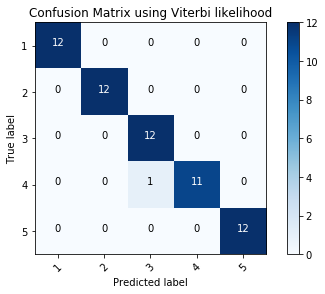

In [18]:
confusion_matrix_stats(predicted_labels, labels,
                       title='Confusion Matrix using Viterbi likelihood')

In [19]:
predicted_labels = []
labels = []
for i in np.arange(12):
    for s in np.arange(5):
        max_ll = -float('inf')
        max_m = -1
        for m in np.arange(len(hmm)):
            ll = hmm[m].forward(signs[s][i][:2, ])
            
            if(ll > max_ll):
                max_ll = ll
                max_m = m
        predicted_labels.append(max_m+1)
        labels.append(s+1)

Confusion matrix, without normalization


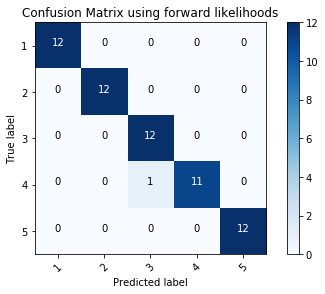

In [20]:
confusion_matrix_stats(predicted_labels, labels,
                       title='Confusion Matrix using forward likelihoods')

# Plagiarism declaration

* I have read and understand the Stellenbosch University Policy on Plagiarism and the def- initions of plagiarism and self-plagiarism contained in the Policy [Plagiarism: The use of the ideas or material of others without acknowledgement, or the re-use of one’s own pre- viously evaluated or published material without acknowledgement or indication thereof (self-plagiarism or text- recycling)].
* I also understand that direct translations are plagiarism.
* Accordingly all quotations and contributions from any source whatsoever (including the internet) have been cited fully.
* I understand that the reproduction of text without quotation marks (even when the source is cited) is plagiarism.
* I declare that the work contained in this assignment is my own work and that I have not previously (in its entirety or in part) submitted it for grading in this module/assignment or another module/assignment.